# **임대주택 단지 내 적정 주차수요 예측 대회**

**[배경]**

아파트 단지 내 필요한 주차대수는 ①법정주차대수 ②장래주차수요 중 큰 값에 따라 결정하게되어 있어, 정확한 ②장래주차수요의 산정을 필요로 합니다.<br>
현재 ②장래주차수요는 ‘주차원단위’와 ‘건축연면적’을 기초로하여 산출되고 있으며,<br>
‘주차원단위’는 신규 건축예정 부지 인근의 유사 단지를 피크 시간대 방문하여 주차된 차량대수를 세는 방법으로 조사하고 있습니다.<br>
이 경우 인력조사로 인한 오차발생, 현장조사 시점과 실제 건축시점과의 시간차 등의 문제로 과대 또는 과소 산정의 가능성을 배제할 수 없습니다.<br>

**[주제]**
유형별 임대주택 설계 시 단지 내 적정 주차 수요를 예측

**[평가]**

- 평가산식 : **MAE(Mean Absolute Error)**
- Public 평가 : 전체 Test 데이터 중 무작위 **33% (50단지)**
- Private 평가 : 전체 Test 데이터 중 나머지 **67% (100단지)**

**[외부 데이터 및 사전학습 모델]**

- 공공 데이터와 같이 누구나 얻을 수 있고 법적 제약이 없는 **외부 데이터 허용**
- 사전학습 모델의 경우 **사전학습에 사용된 데이터를 명시**해야함
- 최종 평가시 외부데이터 및 출처 제출

# Data Understanding

**train.csv - 학습용 데이터**

- 단지코드(key)
- 총세대수
- 임대건물구분
- 지역
- 공급유형
- 전용면적
- 전용면적별세대수
- 공가수: 빈집
- 자격유형: 임차를 할 수 있는 자격 요건
- 임대료보증금
- 임대료
- 도보 10분거리 내 지하철역 수(환승노선 수 반영)
- 도보 10분거리 내 버스정류장 수
- 단지내주차면수
- 등록차량수(target)

**age_gender_info.csv - 지역 임대주택 나이별, 성별 인구 분포**

- 지역
- 10대미만(여자)
- 10대미만(남자)
- 20대(여자)
- 20대(남자)
- 30대(여자)
- 30대(남자)
- 40대(여자)
- 40대(남자)
- 50대(여자)
- 50대(남자)
- 60대(여자)
- 60대(남자)
- 70대(여자)
- 70대(남자)
- 80대(여자)
- 80대(남자)
- 90대(여자)
- 90대(남자)
- 100대(여자)
- 100대(남자)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [43]:
age_gender = pd.read_csv('data/age_gender_info.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [51]:
aa = train.groupby(['단지코드', '전용면적', '전용면적별세대수'])['자격유형']
aa.head)

SyntaxError: unmatched ')' (<ipython-input-51-be795d5290a1>, line 2)

In [40]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,2952.0,886.661247,513.540168,26.00,513.50,779.00,1106.0000,2568.0
전용면적,2952.0,44.757215,31.874280,12.62,32.10,39.93,51.5625,583.4
전용면적별세대수,2952.0,102.747967,132.640159,1.00,14.00,60.00,144.0000,1865.0
공가수,2952.0,12.921070,10.778831,0.00,4.00,11.00,20.0000,55.0
도보 10분거리 내 지하철역 수(환승노선 수 반영),2741.0,0.176578,0.427408,0.00,0.00,0.00,0.0000,3.0
도보 10분거리 내 버스정류장 수,2948.0,3.695726,2.644665,0.00,2.00,3.00,4.0000,20.0
단지내주차면수,2952.0,601.668360,396.407072,13.00,279.25,517.00,823.0000,1798.0
등록차량수,2952.0,559.768293,433.375027,13.00,220.00,487.00,770.0000,2550.0


In [9]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,1022.0,862.080235,536.340894,75.00,488.000,745.00,1161.0,2572.0
전용면적,1022.0,43.706311,35.890759,9.96,33.135,39.72,47.4,583.4
전용면적별세대수,1022.0,100.414873,125.997855,1.00,14.000,60.00,140.0,1341.0
공가수,1022.0,15.544031,11.070140,0.00,6.000,15.00,23.0,45.0
도보 10분거리 내 지하철역 수(환승노선 수 반영),980.0,0.136735,0.435500,0.00,0.000,0.00,0.0,2.0
도보 10분거리 내 버스정류장 수,1022.0,4.626223,5.414568,1.00,2.000,3.00,5.0,50.0
단지내주차면수,1022.0,548.771037,342.636703,29.00,286.000,458.00,711.0,1696.0


- train set과 test set 의 평균과 편차가 큰 차이가 없습니다.

# age_gender_info

In [10]:
ag = age_gender.set_index('지역')

In [11]:
ag.loc['전체 평균'] = ag.mean()
ag.loc['광역시 평균'] = ag.loc[(ag.index.str.contains('시')) & (~ag.index.str.contains('세종'))].mean()
ag.loc['도 평균'] = ag.loc[ag.index.str.contains('도')].mean()

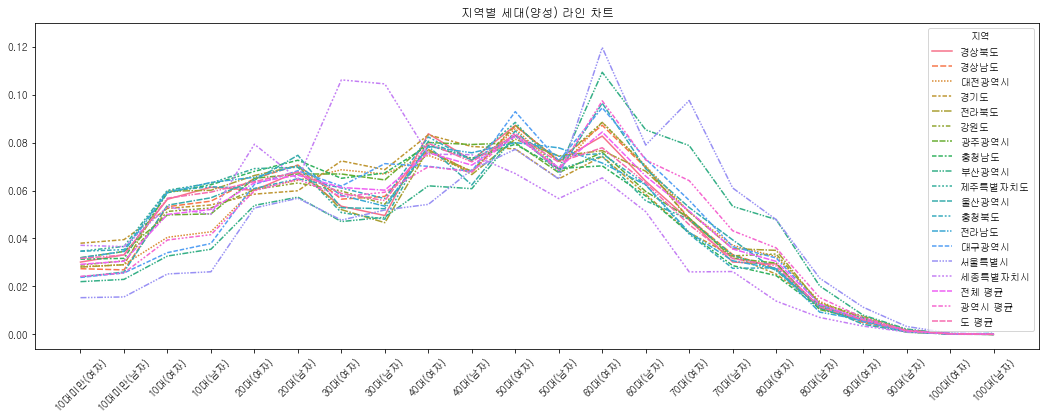

In [12]:
fig = plt.figure(figsize = (18, 6))
sns.lineplot(data=ag.T, )
plt.title('지역별 세대(양성) 라인 차트')
plt.xticks(rotation=45)
plt.ylim(top=0.13)
plt.show()

- 비교적 정규 분포의 모양을 띄고 있습니다.
- 같은 나이대임에도 성별에 따라 편차가 존재합니다. 대체로 남성보다는 여성이 높은 비율을 보이고 있습니다.
- 서울특별시는 60대 여성, 70대 여성에서 피크를 보이고 있습니다.
- 부산광역시 또한 서울과 비슷한 패턴을 보입니다.
- 세종특별자치시는 다른 시도와는 다르게 30대에서 매우 높은 비중을 보입니다.

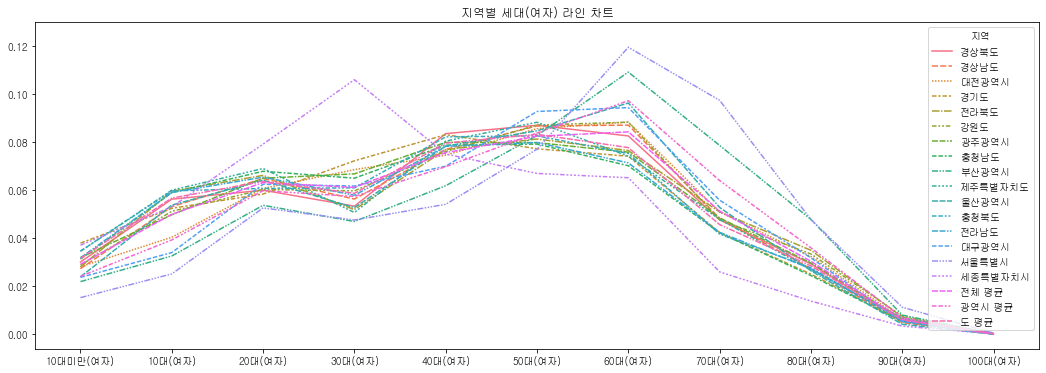

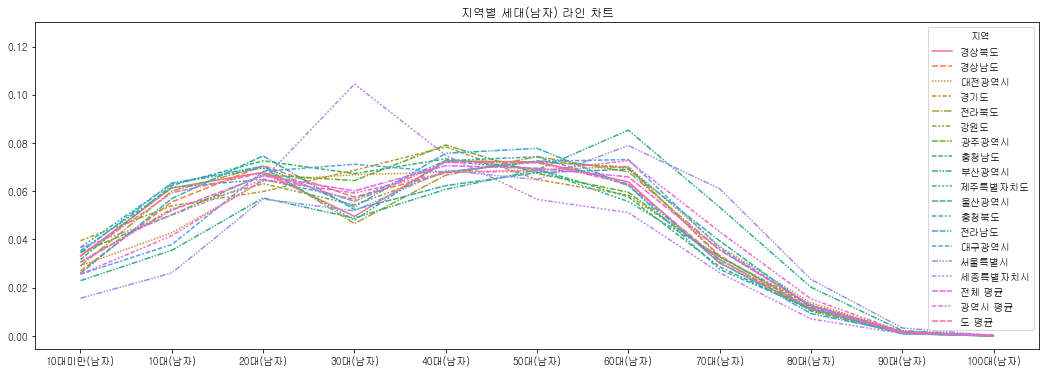

In [13]:
fig = plt.figure(figsize = (18, 6))
sns.lineplot(data=ag.loc[:, ag.columns.str.contains('여자')].T)
plt.title('지역별 세대(여자) 라인 차트')
plt.ylim(top=0.13)
plt.show()

fig = plt.figure(figsize = (18, 6))
sns.lineplot(data=ag.loc[:, ag.columns.str.contains('남자')].T)
plt.title('지역별 세대(남자) 라인 차트')
plt.ylim(top=0.13)
plt.show()

- 성별을 기준으로 따로 플롯을 그려보았을 때, 절대적인 비율의 차이는 있지만, 패턴은 똑같습니다.

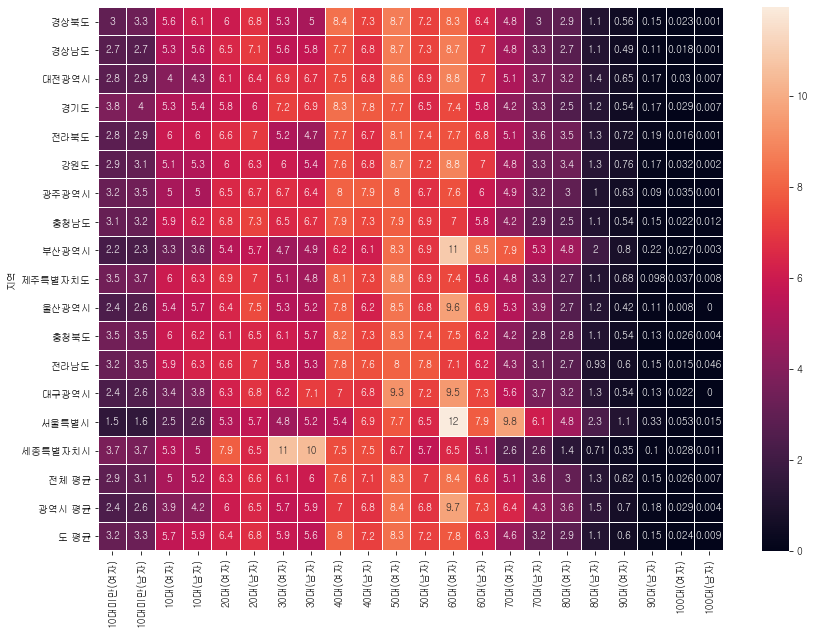

In [14]:
plt.figure(figsize=(14, 10))
sns.heatmap((ag*100).round(3),
           annot=True, linewidths=0.01,)

plt.show()

- 인구가 많은 특별시, 광역시에서 60~70대의 비중이 높은 것을 알 수 있습니다. (서울, 부산, 울산, 대구 등)
- 앞서 보았듯이 세종은 청년층 20~30대의 비중이 매우 높게 형성되어 있습니다.
- 광역시(세종 제외)와 도단위 지역구의 평균을 비교했을 때, 10대와 40대, 60~70대에서 차이가 두드러집니다.

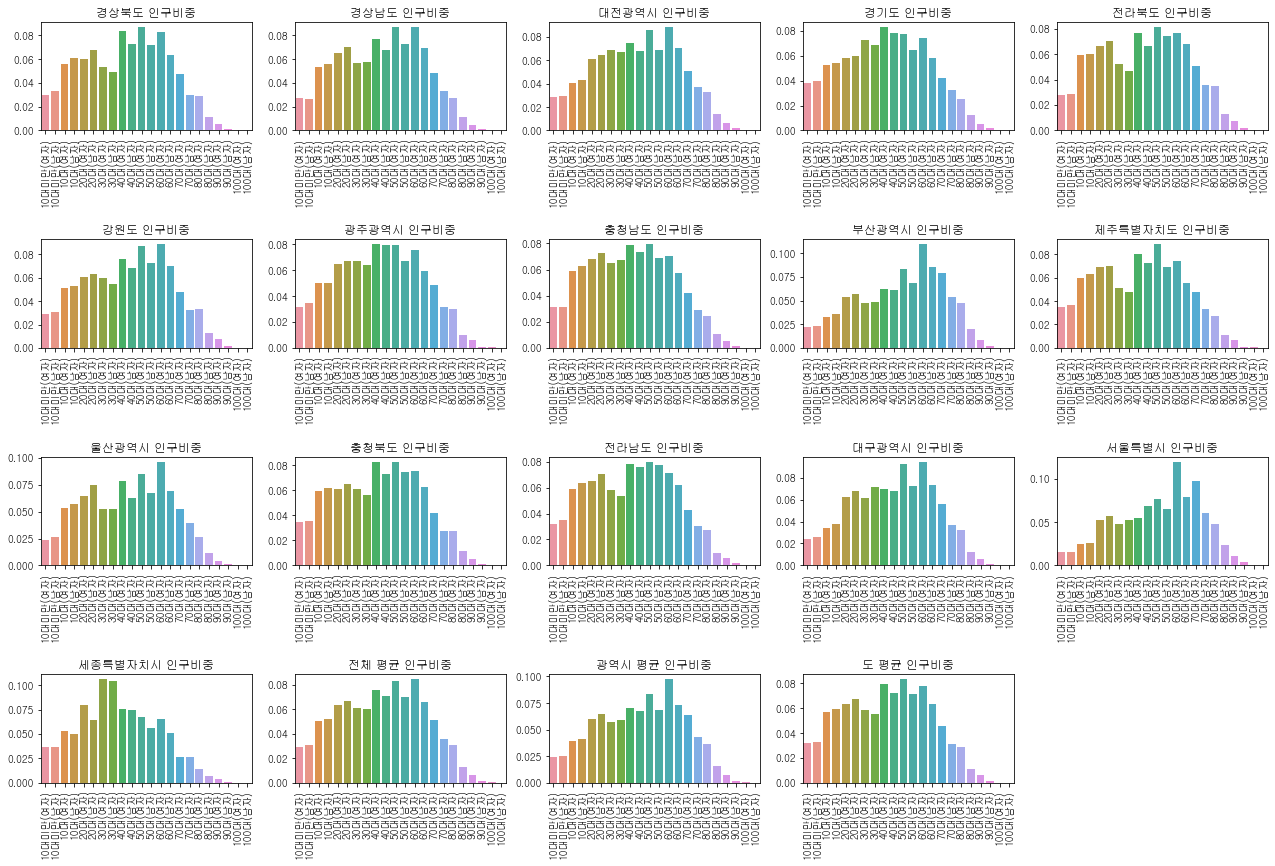

In [15]:
fig = plt.figure(figsize=(22, 18))
plt.xticks(rotation=90)
for i, n in enumerate(list(ag.index)):
    plt.subplot(5, 5, i+1)
    plt.subplots_adjust(hspace=1.0)
    plt.title("{} 인구비중".format(n))
    sns.barplot(data=ag.loc[ag.index == n])
    plt.xticks(rotation=90)

- 각 행정구역별로 바플롯을 그려보았을 때, 앞서 살펴 본 특징들을 확인할 수 있습니다.
- 세종을 제외하고는 크게 두 패턴으로 나뉘는 것을 알 수 있습니다.

# train/test

먼저 기본적인 컬럼별 밸류 체크부터 하겠습니다.

### Train/Test-Column-Values-Check

In [16]:
def check_train_test_column_values(train, test, column):
    # 함수 정의: 두 데이터 테이블과 특정 컬럼을 집어 넣으면 value를 비교하여 출력하는 함수
    print("{} Column에 대한 train_test_values_check 입니다=======================".format(column))
    # Train/Test set의 입력 칼럼의 value를 set으로 받아줍니다.
    train_colset = set(train[column])
    test_colset  = set(test[column])

    # Train/Test-set 고유한 value의 개수를 구함.
    print(f"Train-set에 있는 고유한 value 개수 : {len(train_colset)}")
    print(f"Test-set에 있는 고유한 value 개수 : {len(test_colset)}")

    # Train/Test-set 모두에 포함되어있는 value를 구함.
    print('='* 80)
    common_colset = train_colset.intersection(test_colset)
    print(f"Train/Test-set에 공통으로 포함되어 있는 value 개수 : {len(common_colset)}")
    if len(common_colset) > 100: # value가 너무 많으면 어차피 보기 힘드므로 출력을 pass 합니다
        pass
    else:
        try: # int나 float은 sorted가 먹지 않기 때문에 try except로 넣어줍니다.
            print(f"Train/Test-set에 공통으로 포함되어 있는 value : {sorted(common_colset)}")
        except:
            print(f"Train/Test-set에 공통으로 포함되어 있는 value : {(common_colset)}")

    # Train-set에만 있는 value를 구함.
    print('='* 80)
    train_only_colset = train_colset.difference(test_colset)
    print(f"Train-set에만 있는 value는 총 {len(train_only_colset)} 개 입니다.")
    if len(train_only_colset) > 100:
        pass
    else:
        try:
            print(f"Train-set에만 있는 value는 : {sorted(train_only_colset)}")
        except:
            print(f"Train-set에만 있는 value는 : {(train_only_colset)}")

    # Test-set에만 있는 value를 구함.
    print('='* 80)
    test_only_colset = test_colset.difference(train_colset)
    print(f"Test-set에만 있는 value는 총 {len(test_only_colset)} 개 입니다.")
    if len(test_only_colset) > 100:
        pass
    else:
        try:
            print(f"Test-set에만 있는 value는 : {sorted(test_only_colset)}")
        except:
            print(f"Test-set에만 있는 value는 : {(test_only_colset)}")
    print(" ")

In [17]:
obj_cols = []
for col in train.columns:
    if train[col].dtypes == 'object':
        obj_cols.append(col)

In [18]:
for col in obj_cols:
    check_train_test_column_values(train, test, col)

단지코드 Column에 대한 train_test_values_check 입니다=======================
Train-set에 있는 고유한 value 개수 : 423
Test-set에 있는 고유한 value 개수 : 150
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 0
Train/Test-set에 공통으로 포함되어 있는 value : []
Train-set에만 있는 value는 총 423 개 입니다.
Test-set에만 있는 value는 총 150 개 입니다.
 
임대건물구분 Column에 대한 train_test_values_check 입니다=======================
Train-set에 있는 고유한 value 개수 : 2
Test-set에 있는 고유한 value 개수 : 2
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 2
Train/Test-set에 공통으로 포함되어 있는 value : ['상가', '아파트']
Train-set에만 있는 value는 총 0 개 입니다.
Train-set에만 있는 value는 : []
Test-set에만 있는 value는 총 0 개 입니다.
Test-set에만 있는 value는 : []
 
지역 Column에 대한 train_test_values_check 입니다=======================
Train-set에 있는 고유한 value 개수 : 16
Test-set에 있는 고유한 value 개수 : 15
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 15
Train/Test-set에 공통으로 포함되어 있는 value : ['강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도']
Train-set에만 있는 value는 총 1 개 입니다.
T

- train set과 test set 간의 컬럼별 밸류 차이가 다소 존재합니다.

train 데이터는 2개의 테이블이 합쳐진 것으로 판단 됩니다.

- 아파트 단지 타입별로 나뉘어진 테이블과
- 아파트 단지의 정보가 담긴 테이블입니다.
- 또한 아파트 단지에 대한 정보를 아파트 유형과 상가 유형으로 나눌 수 있습니다.

In [19]:
train_apart = train[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형', '임대보증금', '임대료']].loc[train['임대건물구분'] == '아파트']

In [20]:
train_shop = train[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형']].loc[train['임대건물구분'] == '상가']

In [21]:
train_danji = train[['단지코드', '총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수']].drop_duplicates()

In [22]:
train_apart.shape, train_shop.shape, train_danji.shape

((2390, 8), (562, 6), (423, 8))

In [23]:
train_apart.head(3)

,단지코드,임대건물구분,공급유형,전용면적,전용면적별세대수,자격유형,임대보증금,임대료
0,C2483,아파트,국민임대,39.72,134,A,15667000,103680
1,C2483,아파트,국민임대,39.72,15,A,15667000,103680
2,C2483,아파트,국민임대,51.93,385,A,27304000,184330


In [24]:
train_shop.head(3)

,단지코드,임대건물구분,공급유형,전용면적,전용면적별세대수,자격유형
88,C1925,상가,임대상가,32.1,1,D
89,C1925,상가,임대상가,32.1,1,D
90,C1925,상가,임대상가,32.1,1,D


In [25]:
train_danji.head(3)

,단지코드,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0
8,C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0
15,C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0


- train set의 단지는 총 423개입니다.

In [26]:
test_apart = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형', '임대보증금', '임대료']].loc[test['임대건물구분'] == '아파트']

In [27]:
test_shop = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형']].loc[test['임대건물구분'] == '상가']

In [28]:
test_danji = test[['단지코드', '총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수']].drop_duplicates()

In [29]:
test_apart.shape, test_shop.shape, test_danji.shape

((845, 8), (177, 6), (150, 7))

In [30]:
test_apart.head(3)

,단지코드,임대건물구분,공급유형,전용면적,전용면적별세대수,자격유형,임대보증금,임대료
0,C1072,아파트,국민임대,39.79,116,H,22830000,189840
1,C1072,아파트,국민임대,46.81,30,A,36048000,249930
2,C1072,아파트,국민임대,46.90,112,H,36048000,249930


In [31]:
test_shop.head(3)

,단지코드,임대건물구분,공급유형,전용면적,전용면적별세대수,자격유형
80,C1006,상가,임대상가,38.00,1,D
81,C1006,상가,임대상가,38.00,1,D
82,C1006,상가,임대상가,37.26,1,D


In [32]:
test_danji.head(3)

,단지코드,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,경기도,14.0,0.0,2.0,683.0
8,C1128,1354,경기도,9.0,0.0,3.0,1216.0
17,C1456,619,부산광역시,18.0,0.0,16.0,547.0


- test set의 단지는 총 150개 입니다. 이중 50/100 개로 나뉘어 평가합니다.

## NA Values

결측치부터 살펴보겠습니다.

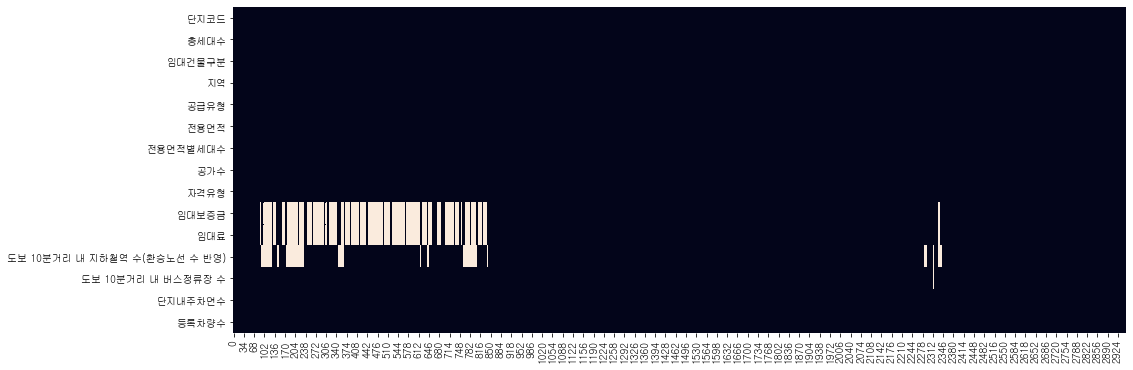

In [33]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.isnull().T, cbar=False)
plt.show()

In [34]:
train.isnull().sum().to_frame()

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,0
임대보증금,569


- 임대보증금, 임대료, 지하철역, 버스정류장 에서 결측치가 있습니다.
- 임대보증금, 임대료에서의 결측치는 등장하는 row가 동일해 보입니다.

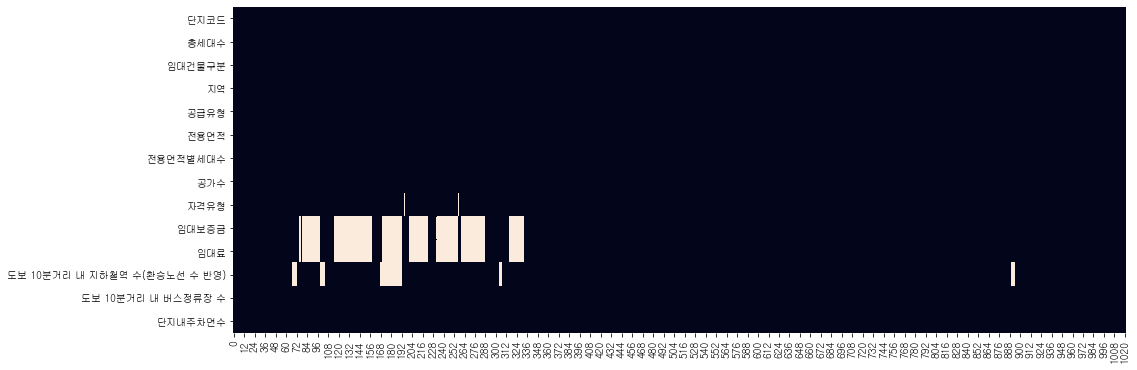

In [35]:
plt.figure(figsize=(16, 6))
sns.heatmap(test.isnull().T, cbar=False)
plt.show()

In [36]:
test.isnull().sum().to_frame()

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,2
임대보증금,180


- test set에서는 자격유형에서 결측치가 조금 보입니다.
- 그리고 지하철역에서 결측치가 많이 보입니다.

### NA of Subway

In [37]:
train.loc[train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()].sample(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
362,C1983,903,상가,충청남도,임대상가,31.84,1,3.0,D,NaN,NaN,NaN,4.0,200.0,253.0
218,C2258,965,상가,대전광역시,임대상가,19.00,1,13.0,D,NaN,NaN,NaN,3.0,287.0,78.0
215,C2258,965,아파트,대전광역시,영구임대,26.37,588,13.0,C,5787000,79980,NaN,3.0,287.0,78.0
125,C1874,619,상가,충청남도,임대상가,55.17,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0
783,C1875,1003,아파트,충청남도,영구임대,26.37,596,5.0,C,3141000,69900,NaN,8.0,192.0,209.0


In [38]:
print('전체 단지 수: ', train['단지코드'].nunique())
print('지하철 결측치 단지 수: ', train.loc[train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()]['단지코드'].nunique())
print('지하철 결측치 단지: ', train.loc[train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()]['단지코드'].unique())
print('지하철 결측치 단지 지역: ', train.loc[train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()]['지역'].unique())

전체 단지 수:  423
지하철 결측치 단지 수:  20
지하철 결측치 단지:  ['C1312' 'C1874' 'C1424' 'C2100' 'C2520' 'C1616' 'C1704' 'C2258' 'C1068'
 'C1983' 'C2216' 'C2644' 'C1005' 'C1004' 'C1875' 'C2156' 'C1175' 'C2583'
 'C1649' 'C1350']
지하철 결측치 단지 지역:  ['충청남도' '대전광역시' '경상남도']


- 지하철 결측값은 총 20개의 단지에서 발생했습니다.
- 지하철 결측값은 충남, 대전, 경남에서만 발생하였습니다.
- 해당 지역에 지하철이 없더라도 0.0 으로 값이 채워져 있는 단지가 있습니다.
- 따라서 패턴이 없는 단순 결측치로 보입니다.
- 그러나 충남 북부나, 경남 남부 같은 경우는 지하철이 있는 도시가 있습니다. 마찬가지로 대전은 대전지하철이 있습니다. 결측치를 어떻게 채울지 고심해봐야 합니다.

In [40]:
test.loc[test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()].sample(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
174,C2177,1245,상가,충청남도,임대상가,18.38,1,2.0,D,NaN,NaN,NaN,1.0,187.0
101,C1083,427,아파트,대전광역시,국민임대,51.48,64,0.0,A,32459000,187260,NaN,6.0,384.0
188,C2177,1245,상가,충청남도,임대상가,33.51,1,2.0,D,NaN,NaN,NaN,1.0,187.0
102,C1083,427,아파트,대전광역시,국민임대,51.99,107,0.0,A,32459000,187260,NaN,6.0,384.0
180,C2177,1245,상가,충청남도,임대상가,21.94,1,2.0,D,NaN,NaN,NaN,1.0,187.0


In [41]:
print('전체 단지 수: ', test['단지코드'].nunique())
print('지하철 결측치 단지 수: ', test.loc[test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()]['단지코드'].nunique())
print('지하철 결측치 단지: ', test.loc[test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()]['단지코드'].unique())
print('지하철 결측치 단지 지역: ', test.loc[test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()]['지역'].unique())

전체 단지 수:  150
지하철 결측치 단지 수:  5
지하철 결측치 단지:  ['C1472' 'C1083' 'C2177' 'C1318' 'C1327']
지하철 결측치 단지 지역:  ['충청남도' '대전광역시']


- test set에서는 5개 단지에서 지하철 정보가 없습니다. 전부 충남과 대전입니다.

### NA of BusStop

In [42]:
train.loc[train['도보 10분거리 내 버스정류장 수'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
2315,C1649,575,아파트,경상남도,공공임대(10년),74.97,80,15.0,A,46000000,456000,NaN,NaN,1066.0,855.0
2316,C1649,575,아파트,경상남도,공공임대(10년),84.95,124,15.0,A,57000000,462000,NaN,NaN,1066.0,855.0
2317,C1649,575,아파트,경상남도,공공임대(10년),84.96,289,15.0,A,57000000,462000,NaN,NaN,1066.0,855.0
2318,C1649,575,아파트,경상남도,공공임대(10년),84.98,82,15.0,A,57000000,462000,NaN,NaN,1066.0,855.0


In [43]:
train.loc[train['도보 10분거리 내 버스정류장 수'].isnull()]['지역'].unique()

array(['경상남도'], dtype=object)

- 버스 정류장 데이터가 없는 단지는 단 하나 뿐입니다.
- test set에는 없습니다.

### NA of 임대보증금, 임대료

#### **아파트 유형**

자격유형이 D형인 아파트에만 결측치가 있습니다. 그런데 D형은 상가에만 있는 유형입니다. 잘못 입력된 것은 아닌지 의심을 해봐야합니다.

In [44]:
train.loc[(train['임대건물구분'] != '상가') & (train['임대보증금'].isnull())]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
2331,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2332,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2333,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2334,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2335,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2336,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2337,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0


In [45]:
test.loc[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull())]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
76,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,NaN,2.0,5.0,428.0
77,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,NaN,2.0,5.0,428.0
79,C1006,1505,아파트,대전광역시,영구임대,52.74,6,27.0,D,NaN,NaN,2.0,5.0,428.0


- train, test 에서 임대보증금과 임대료가 결측치인 단지가 1개씩 존재합니다.

#### **상가 유형**

In [46]:
train.loc[train['단지코드'] == 'C1004'].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
764,C1004,521,아파트,충청남도,영구임대,39.30,240,3.0,C,4682000,104180,NaN,2.0,153.0,93.0
765,C1004,521,아파트,충청남도,영구임대,39.69,264,3.0,C,4728000,105210,NaN,2.0,153.0,93.0
766,C1004,521,상가,충청남도,임대상가,19.00,1,3.0,D,NaN,NaN,NaN,2.0,153.0,93.0
767,C1004,521,상가,충청남도,임대상가,14.10,1,3.0,D,NaN,NaN,NaN,2.0,153.0,93.0
768,C1004,521,상가,충청남도,임대상가,19.31,1,3.0,D,NaN,NaN,NaN,2.0,153.0,93.0


In [47]:
len(train.loc[train['임대건물구분'] == '상가'])

562

In [48]:
train.loc[train['임대건물구분'] == '상가'].isnull().sum().to_frame()

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,0
임대보증금,562


- 아파트 단지에 상가가 있는 경우가 있습니다.
- 상가는 임대보증금, 임대료가 전부 결측치입니다.

In [49]:
print('전체 단지 수: ', train['단지코드'].nunique())
print('상가 보유 단지 수: ', train.loc[train['임대건물구분'] == '상가']['단지코드'].nunique())
print('상가 보유 단지: ', train.loc[train['임대건물구분'] == '상가']['단지코드'].unique())
print('상가 보유 단지 지역: ', train.loc[train['임대건물구분'] == '상가']['지역'].unique())

전체 단지 수:  423
상가 보유 단지 수:  33
상가 보유 단지:  ['C1925' 'C1874' 'C2416' 'C2621' 'C1616' 'C1704' 'C2258' 'C2038' 'C1859'
 'C1722' 'C2190' 'C1476' 'C1983' 'C2135' 'C2034' 'C1109' 'C2289' 'C2597'
 'C2310' 'C2132' 'C1439' 'C1899' 'C1056' 'C2644' 'C1206' 'C1775' 'C1790'
 'C2109' 'C1698' 'C1004' 'C1875' 'C2212' 'C2571']
상가 보유 단지 지역:  ['강원도' '충청남도' '경상남도' '대전광역시' '부산광역시' '제주특별자치도']


- 총 33개 단지에서 상가를 보유하고 있습니다.
- 지역도 매우 다양합니다.

In [50]:
len(test.loc[test['임대건물구분'] == '상가'])

177

In [51]:
test.loc[test['임대건물구분'] == '상가'].isnull().sum().to_frame()

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,0
임대보증금,177


- train set과 마찬가지로 test set에서도 상가건물은 임대보증금과 임대료가 결측치입니다.

In [52]:
print('전체 단지 수: ', test['단지코드'].nunique())
print('상가 보유 단지 수: ', test.loc[test['임대건물구분'] == '상가']['단지코드'].nunique())
print('상가 보유 단지: ', test.loc[test['임대건물구분'] == '상가']['단지코드'].unique())
print('상가 보유 단지 지역: ', test.loc[test['임대건물구분'] == '상가']['지역'].unique())

전체 단지 수:  150
상가 보유 단지 수:  7
상가 보유 단지:  ['C1006' 'C2676' 'C2177' 'C2033' 'C1812' 'C2253' 'C1729']
상가 보유 단지 지역:  ['대전광역시' '부산광역시' '충청남도' '울산광역시' '강원도']


- test set에서는 총 7개 단지에서 상가가 있으며
- 대전, 부산, 충남, 울산, 강원에 있습니다.

### NA of 자격유형

test set에서 자격유형의 결측치가 존재합니다.

In [53]:
test.loc[test['자격유형'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


- test set의 2개 단지에서 자격유형에 대한 결측치가 보입니다.

## Columns

### 변수별 분포 확인

In [55]:
numeric_cols = []
for col in train.columns:
    if train[col].dtypes != 'object':
        numeric_cols.append(col)

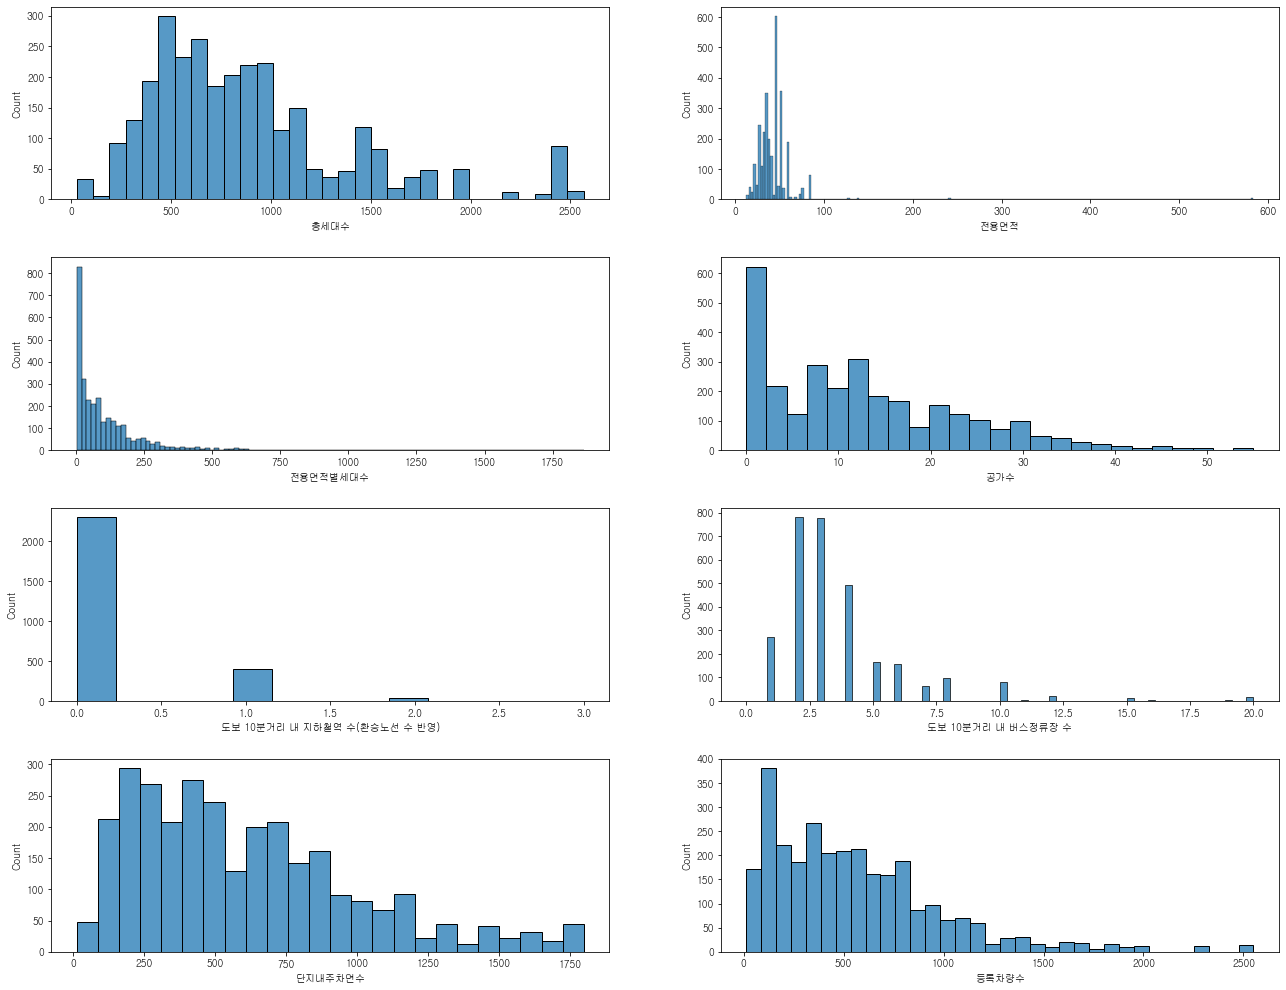

In [56]:
fig = plt.figure(figsize=(22, 22))
for i, n in enumerate(numeric_cols):
    plt.subplot(5, 2, i+1)
    plt.subplots_adjust(hspace=0.3)
    sns.histplot(train[n])

- 전용면적, 전용면적별세대수 컬럼은 매우 skew한 분포를 띄고 있습니다.
- 총세대수, 단지내주차면서, 등록차량수 컬럼 또한 꼬리에서 튀어오르고 있습니다.
- 아웃라이어라고 할 수 있는 대단지가 존재하는 것으로 보입니다.

In [57]:
train.loc[train[['단지코드']].drop_duplicates().index][['단지코드', '총세대수']].nlargest(3, '총세대수')

,단지코드,총세대수
2511,C1363,2568
522,C2132,2428
261,C1859,2424


In [58]:
train.loc[train[['단지코드']].drop_duplicates().index][['단지코드', '총세대수']].nsmallest(3, '총세대수')

,단지코드,총세대수
2821,C2059,26
2942,C2020,40
2200,C2237,70


- 2568 세대가 있는 단지부터 26 세대 뿐인 단지까지 있습니다.

In [59]:
train.loc[train[['단지코드']].drop_duplicates().index][['단지코드', '등록차량수']].nlargest(3, '등록차량수')

,단지코드,등록차량수
2511,C1363,2550.0
2331,C1350,2315.0
2619,C1802,1983.0


In [60]:
train.loc[train[['단지코드']].drop_duplicates().index][['단지코드', '등록차량수']].nsmallest(3, '등록차량수')

,단지코드,등록차량수
2821,C2059,13.0
2945,C2437,16.0
822,C2401,19.0


- 2550대가 등록 된 단지부터 13대만 등록되어 있는 단지까지 있습니다.

### 총세대수

In [61]:
train.loc[train['단지코드'] == 'C1004']['전용면적별세대수'].sum()

521

- 총세대수는 상가 세대수까지 합친 숫자입니다.

In [62]:
(train.groupby(['단지코드'])['전용면적별세대수'].sum() != 
 train.groupby(['단지코드'])['총세대수'].max()).sum()

40

- 총세대수와 전용면적별세대수 합이 맞지 않는 단지가 40개 단지 있습니다.

In [63]:
train_danji.set_index('단지코드').loc[(train.groupby(['단지코드'])['전용면적별세대수'].sum() != 
 train.groupby(['단지코드'])['총세대수'].max())]

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
단지코드,,,,,,,
C1925,601,강원도,9.0,0.0,4.0,117.0,75.0
C1312,518,충청남도,12.0,NaN,3.0,527.0,359.0
C2013,595,경상남도,3.0,0.0,3.0,509.0,91.0
C1424,625,대전광역시,2.0,NaN,7.0,517.0,179.0
C2520,970,대전광역시,2.0,NaN,2.0,420.0,386.0
C2319,606,대전광역시,1.0,1.0,12.0,548.0,266.0
C1850,388,경상남도,0.0,0.0,4.0,226.0,254.0
C1068,806,충청남도,11.0,NaN,2.0,804.0,510.0
C2644,779,충청남도,7.0,NaN,12.0,190.0,177.0


In [64]:
unmatch_danji_list = list(train_danji.set_index('단지코드').loc[(train.groupby(['단지코드'])['전용면적별세대수'].sum() != 
 train.groupby(['단지코드'])['총세대수'].max())].index)

In [65]:
train.loc[train['단지코드'].isin(unmatch_danji_list)].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
86,C1925,601,아파트,강원도,영구임대,26.37,298,9.0,C,8052000,130850,0.0,4.0,117.0,75.0
87,C1925,601,아파트,강원도,영구임대,31.32,298,9.0,C,9174000,144460,0.0,4.0,117.0,75.0
88,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
89,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
90,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0


- 상가가 누락되어 부족한 것도 아닙니다. 그냥 안 맞습니다.
- 제공된 데이터는 해당 단지의 모든 정보를 담고 있는 것은 아닌 것 같습니다.
- 누락된 세대수를 어떻게 해결할지 고민을 해봐야할 것 같습니다.

### 지역

In [114]:
train_danji['지역'].value_counts()

경기도        88
경상남도       55
강원도        37
충청북도       30
전라남도       25
대전광역시      25
부산광역시      25
광주광역시      24
경상북도       22
전라북도       21
충청남도       19
대구광역시      18
제주특별자치도    14
울산광역시       8
서울특별시       8
세종특별자치시     4
Name: 지역, dtype: int64

In [115]:
test_danji['지역'].value_counts()

경기도        36
강원도        15
경상남도       14
충청북도       12
경상북도       10
울산광역시       9
전라북도        9
부산광역시       8
광주광역시       7
대구광역시       6
대전광역시       6
제주특별자치도     6
충청남도        5
전라남도        4
세종특별자치시     3
Name: 지역, dtype: int64

- test에 서울이 없습니다.

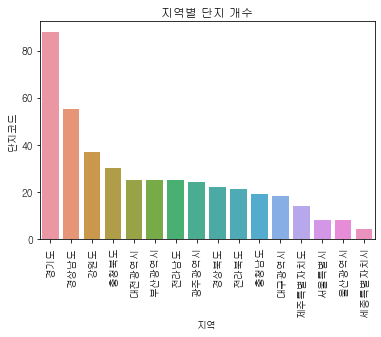

In [128]:
sns.barplot(data=train.groupby(['지역']).nunique().sort_values(by=['단지코드'], ascending=False),
            x=train.groupby(['지역']).nunique().sort_values(by=['단지코드'], ascending=False).index, y='단지코드')
plt.xticks(rotation=90)
plt.title('지역별 단지 개수')
plt.show()

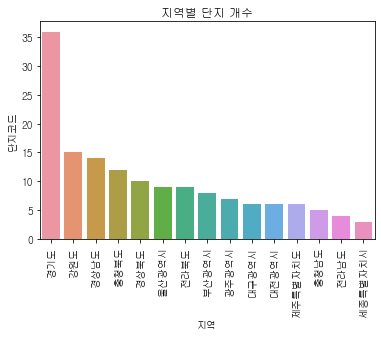

In [129]:
sns.barplot(data=test.groupby(['지역']).nunique().sort_values(by=['단지코드'], ascending=False),
            x=test.groupby(['지역']).nunique().sort_values(by=['단지코드'], ascending=False).index, y='단지코드')
plt.xticks(rotation=90)
plt.title('지역별 단지 개수')
plt.show()

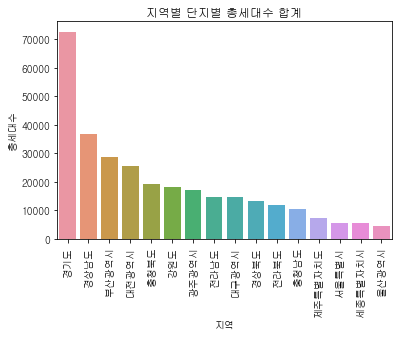

In [131]:
sns.barplot(data=train_danji.groupby(['지역']).sum().sort_values(by=['총세대수'], ascending=False),
            x=train_danji.groupby(['지역']).sum().sort_values(by=['총세대수'], ascending=False).index, y='총세대수')
plt.xticks(rotation=90)
plt.title('지역별 단지별 총세대수 합계')
plt.show()

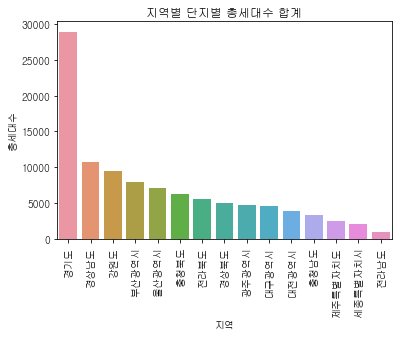

In [132]:
sns.barplot(data=test_danji.groupby(['지역']).sum().sort_values(by=['총세대수'], ascending=False),
            x=test_danji.groupby(['지역']).sum().sort_values(by=['총세대수'], ascending=False).index, y='총세대수')
plt.xticks(rotation=90)
plt.title('지역별 단지별 총세대수 합계')
plt.show()

### 공급유형

In [76]:
train[['단지코드', '공급유형']].drop_duplicates()['공급유형'].value_counts()

국민임대         313
영구임대          56
공공임대(10년)     37
임대상가          33
행복주택          31
공공임대(50년)     11
공공임대(분납)       3
장기전세           2
공공분양           1
공공임대(5년)       1
Name: 공급유형, dtype: int64

In [77]:
test[['단지코드', '공급유형']].drop_duplicates()['공급유형'].value_counts()

국민임대         114
행복주택          17
영구임대          15
공공임대(10년)      9
임대상가           7
공공임대(50년)      3
공공임대(분납)       2
Name: 공급유형, dtype: int64

- 단지별로 지원하는 공급유형을 뽑을 때, 차이가 다소 있습니다.
- train에는 있는 유형이 test에는 없는 것이 많습니다.

In [78]:
train.loc[train['공급유형'] == '공공분양']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
2331,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2332,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2333,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2334,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2335,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2336,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2337,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0


In [79]:
test.loc[test['공급유형'] == '공공분양']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수


- 공급유형에서 공공분양은 train set에 단 하나 밖에 없습니다.
- 임대가 아니라 분양이기에 임대보증금과 임대료가 NA일 수 밖에 없습니다.

In [81]:
train.loc[train['공급유형'] == '장기전세']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
2043,C1397,370,아파트,서울특별시,장기전세,23.32,51,9.0,A,87444000,-,0.0,3.0,1590.0,1595.0
2044,C1397,370,아파트,서울특별시,장기전세,46.79,4,9.0,A,174888000,-,0.0,3.0,1590.0,1595.0
2045,C1397,370,아파트,서울특별시,장기전세,46.91,69,9.0,A,174888000,-,0.0,3.0,1590.0,1595.0
2046,C1397,370,아파트,서울특별시,장기전세,51.96,24,9.0,A,194562000,-,0.0,3.0,1590.0,1595.0
2047,C1397,370,아파트,서울특별시,장기전세,51.99,80,9.0,A,194562000,-,0.0,3.0,1590.0,1595.0
2048,C1397,370,아파트,서울특별시,장기전세,59.93,142,9.0,A,216423000,-,0.0,3.0,1590.0,1595.0
2100,C1039,790,아파트,서울특별시,장기전세,51.32,126,13.0,A,187694000,-,0.0,3.0,673.0,645.0
2101,C1039,790,아파트,서울특별시,장기전세,59.88,49,13.0,A,213863000,-,0.0,3.0,673.0,645.0
2102,C1039,790,아파트,서울특별시,장기전세,59.94,75,13.0,A,213863000,-,0.0,3.0,673.0,645.0


- 장기전세는 전세이기 때문에 임대료가 없습니다.

In [126]:
train.groupby(['공급유형']).sum()

,총세대수,전용면적,전용면적별세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
공급유형,,,,,,,,
공공분양,9807,564.63,711,14.0,0.0,42.0,11452.0,16205.0
공공임대(10년),181349,14585.68,24965,1855.0,15.0,726.0,192054.0,237745.0
공공임대(50년),20188,1360.85,6094,75.0,2.0,152.0,9401.0,9739.0
공공임대(5년),1908,146.66,406,3.0,3.0,6.0,2316.0,2661.0
공공임대(분납),10744,913.38,1120,6.0,0.0,45.0,14726.0,16956.0
국민임대,1364023,78249.18,213854,25278.0,233.0,6573.0,1209229.0,1133252.0
영구임대,167934,4395.13,36347,1315.0,43.0,567.0,68357.0,57781.0
임대상가,701025,25498.79,562,4231.0,170.0,2046.0,150502.0,89017.0
장기전세,4590,452.04,620,93.0,0.0,27.0,11559.0,11505.0


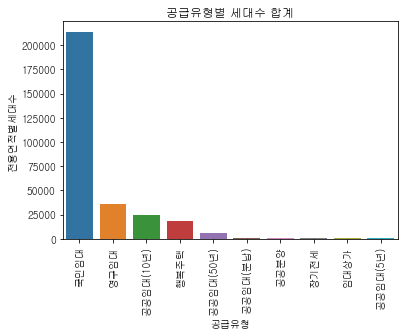

In [134]:
sns.barplot(data=train.groupby(['공급유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False),
            x=train.groupby(['공급유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False).index, y='전용면적별세대수')
plt.xticks(rotation=90)
plt.title('공급유형별 세대수 합계')
plt.show()

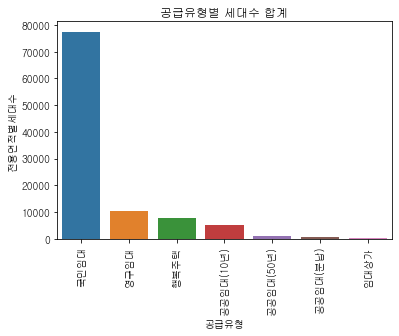

In [138]:
sns.barplot(data=test.groupby(['공급유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False),
            x=test.groupby(['공급유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False).index, y='전용면적별세대수')
plt.xticks(rotation=90)
plt.title('공급유형별 세대수 합계')
plt.show()

- 국민임대가 가장 높은 비율을 차지하고 있습니다.

### 전용면적

In [82]:
train.loc[train['단지코드'] == 'C2612'][['단지코드', '전용면적', '전용면적별세대수', '자격유형', '임대보증금', '임대료']]

,단지코드,전용면적,전용면적별세대수,자격유형,임대보증금,임대료
2463,C2612,29.71,628,A,9800000,154000
2464,C2612,29.71,54,A,9800000,154000
2465,C2612,36.61,620,A,12800000,197000
2466,C2612,46.41,382,A,27500000,257000


- 전용면적이 동일한 데이터가 있어서 알아보니 타입이 다른 것입니다.

웹 서칭을 통해 찾은 정보에 의하면, 면적이 같더라도 타입(구조)가 다릅니다. <br>
즉, **전용면적이 같더라도 타입이 다르고, 전용면적별세대수가 별도로 존재**하는 것입니다.

- 동일한 전용면적을 알파벳으로 보통구분합니다.
- 29A, 29B 등등..으로 바꿔줘야할지 고민해보겠습니다.

### 자격유형

In [85]:
train['자격유형'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O'], dtype=object)

In [86]:
train.groupby(['단지코드', '전용면적', '전용면적별세대수'])['자격유형'].nunique().value_counts()

1    2631
Name: 자격유형, dtype: int64

- 전부 타입당 1개의 신분만을 가집니다.
- 즉, 해당 타입을 임차할 수 있는 자격이 정해져 있습니다.

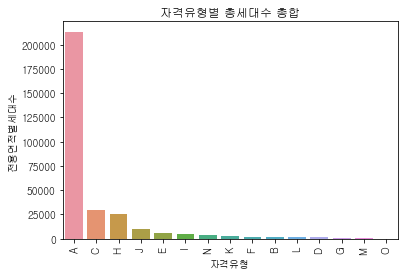

In [139]:
sns.barplot(data=train.groupby(['자격유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False),
            x=train.groupby(['자격유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False).index, y='전용면적별세대수')
plt.title('자격유형별 총세대수 총합')
plt.xticks(rotation=90)
plt.show()

- 자격유형별로 세대수를 모두 더해줬을 때, A가 압도적으로 많은 것을 알 수 있습니다.

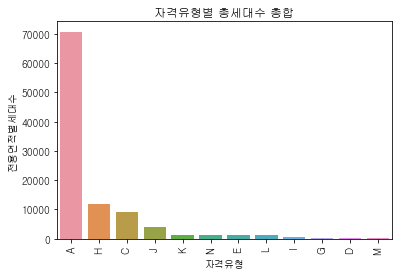

In [140]:
sns.barplot(data=test.groupby(['자격유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False),
            x=test.groupby(['자격유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False).index, y='전용면적별세대수')
plt.title('자격유형별 총세대수 총합')
plt.xticks(rotation=90)
plt.show()

- test셋도 비슷하지만, B가 없습니다.
- F와 O도 없습니다.

In [90]:
train.loc[train['임대건물구분'] == '상가']['자격유형'].value_counts()

D    562
Name: 자격유형, dtype: int64

- D형은 상가유형에만 있습니다. 그러나 앞서 보았듯이 아파트에도 D형이 두 단지 있습니다.
- 동일 단지에 다른 유형으로 채워주겠습니다.

### 지하철

In [91]:
train_danji['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].value_counts()

0.0    359
1.0     38
2.0      5
3.0      1
Name: 도보 10분거리 내 지하철역 수(환승노선 수 반영), dtype: int64

<AxesSubplot:xlabel='지역'>

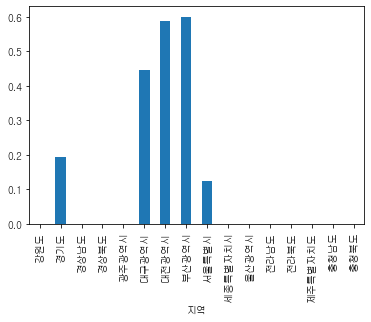

In [92]:
train_danji.groupby(['지역'])['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].mean().plot(kind='bar')

<AxesSubplot:xlabel='지역'>

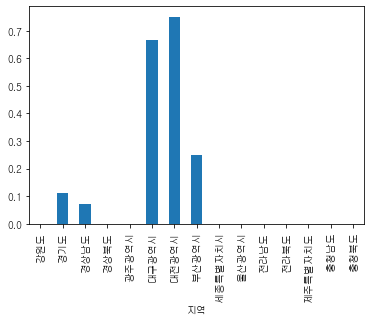

In [93]:
test_danji.groupby(['지역'])['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].mean().plot(kind='bar')

- test_danji에는 경남에 지하철이 있습니다....

### 버스

In [94]:
train_danji['도보 10분거리 내 버스정류장 수'].value_counts()

2.0     113
3.0     104
4.0      64
1.0      45
5.0      27
6.0      25
8.0      13
7.0      10
10.0      8
12.0      4
20.0      3
19.0      1
16.0      1
15.0      1
14.0      1
11.0      1
0.0       1
Name: 도보 10분거리 내 버스정류장 수, dtype: int64

<AxesSubplot:xlabel='지역'>

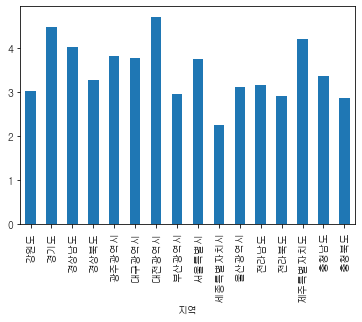

In [95]:
train_danji.groupby(['지역'])['도보 10분거리 내 버스정류장 수'].mean().plot(kind='bar')

In [96]:
train_danji['도보 10분거리 내 버스정류장 수'].value_counts()

2.0     113
3.0     104
4.0      64
1.0      45
5.0      27
6.0      25
8.0      13
7.0      10
10.0      8
12.0      4
20.0      3
19.0      1
16.0      1
15.0      1
14.0      1
11.0      1
0.0       1
Name: 도보 10분거리 내 버스정류장 수, dtype: int64

<AxesSubplot:xlabel='지역'>

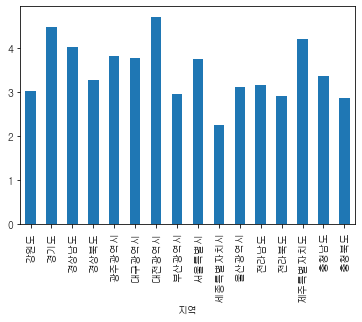

In [97]:
train_danji.groupby(['지역'])['도보 10분거리 내 버스정류장 수'].mean().plot(kind='bar')

### 단지내 주차면수

<AxesSubplot:ylabel='Frequency'>

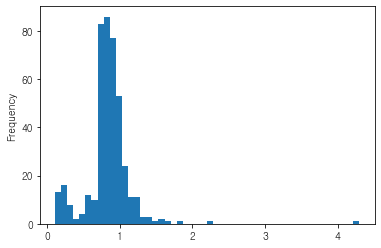

In [98]:
(train_danji['단지내주차면수'] / train_danji['총세대수']).plot(kind='hist', bins=50)

- 단지내주차면수/총세대수 를 구해보면, 대체로 1을 평균으로 정규분포를 띄고 있습니다.
- 그러나 0에 가까운 단지들이 꽤 존재하고, 4가 넘는 outlier도 존재하고 있습니다.

<AxesSubplot:ylabel='Frequency'>

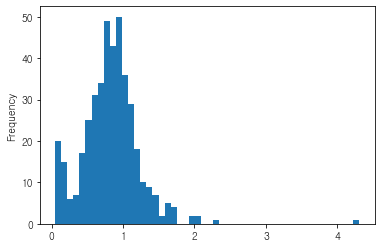

In [99]:
(train_danji['등록차량수'] / train_danji['총세대수']).plot(kind='hist', bins=50)

- 등록차량수의 분포도 비슷하게 형성되는 것을 보았을 때, 매우 근사한 것으로 보입니다.
- 기존 주차면수 측정 방식이 나쁘진 않아보입니다.

<AxesSubplot:ylabel='Frequency'>

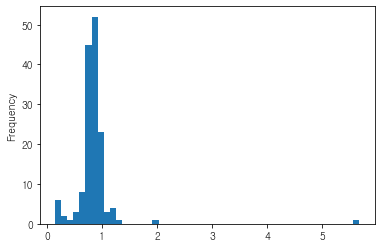

In [100]:
(test_danji['단지내주차면수'] / test_danji['총세대수']).plot(kind='hist', bins=50)

- test도 비슷한 분포를 보입니다.

이상 데이터 이해를 위한 간단한 EDA 였습니다.